<a href="https://colab.research.google.com/github/patsoong/CS506FinalProject/blob/main/notebooks/Logistic_regressor_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


ROC-AUC: 0.966551724137931
Average Precision (PR-AUC): 0.5535403102644482
Binary accuracy: 0.9633333333333334
Top-1 accuracy: 0.7

Predicted vs. True Champions by Season:

 season team_pred team_true  pred_prob  correct
   2016  Warriors Cavaliers   0.996227        0
   2017  Warriors  Warriors   0.998638        1
   2018  Warriors  Warriors   0.970588        1
   2019  Warriors   Raptors   0.561170        0
   2020    Lakers    Lakers   0.064104        1
   2021      Suns     Bucks   0.325509        0
   2022  Warriors  Warriors   0.344731        1
   2023   Nuggets   Nuggets   0.140270        1
   2024   Celtics   Celtics   0.970500        1
   2025   Thunder   Thunder   0.966774        1


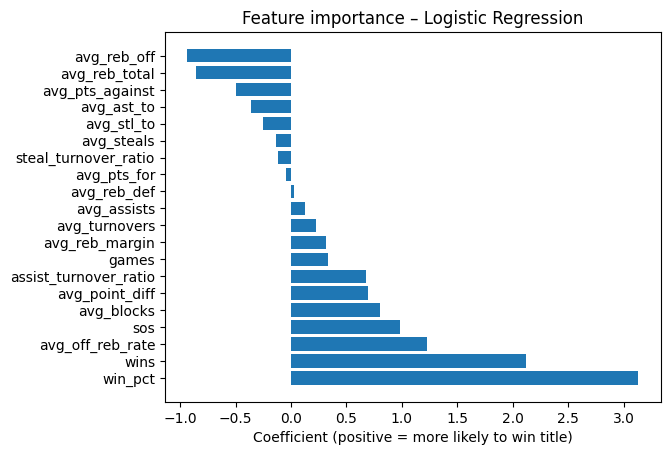

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

features_df = pd.read_csv("team_season_features_v2_clean-2.csv")

num_cols = features_df.select_dtypes(include="number").columns.tolist() #remove features not to be used in training data
for col in ["champion", "season"]:
    if col in num_cols:
        num_cols.remove(col)

X = features_df[num_cols].copy()
X = X.replace([np.inf, -np.inf], np.nan)
y = features_df["champion"].astype(int)

#temporal split
train_mask = features_df["season"] <= 2015
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

id_test = features_df.loc[~train_mask, ["season", "team", "champion"]].copy()

model = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(multi_class='ovr', class_weight='balanced', max_iter=10000))
])

model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

# measures how well your model can rank positive examples (champions) above
# negatives (non-champions), across all possible probability thresholds
# ROC-AUC = probability that your model assigns a higher predicted probability to the champion
# How well does the model rank real champions higher than others?
# how well it ranks teams overall
print("ROC-AUC:", roc_auc_score(y_test, probabilities))

# emphasizes performance on the positive class
# How well does the model focus on the true champion cases out of all possible teams?
# how good it is at finding the actual champions
print("Average Precision (PR-AUC):", average_precision_score(y_test, probabilities))

pred_labels = (probabilities > 0.5).astype(int)
print("Binary accuracy:", accuracy_score(y_test, pred_labels))

id_test["proba_win"] = probabilities

idx = id_test.groupby("season")["proba_win"].idxmax()

predicted_champs = (
    id_test.loc[idx, ["season", "team", "proba_win"]]
           .rename(columns={"team": "team_pred", "proba_win": "pred_prob"})
           .reset_index(drop=True)
)

true_champs = (
    id_test.loc[id_test["champion"] == 1, ["season", "team"]]
           .rename(columns={"team": "team_true"})
           .reset_index(drop=True)
)

eval = predicted_champs.merge(true_champs, on="season", suffixes=("_pred", "_true"))
eval["correct"] = (eval["team_pred"] == eval["team_true"]).astype(int)
print("Top-1 accuracy:", eval["correct"].mean())

print("\nPredicted vs. True Champions by Season:\n")
print(eval[["season", "team_pred", "team_true", "pred_prob", "correct"]]
      .sort_values("season")
      .to_string(index=False))


# Positive coefficient → higher value of that feature increases the predicted chance of winning the title
# Negative coefficient → higher value of that feature decreases the predicted chance of winning the title
coefs = model.named_steps["clf"].coef_[0]
coef_df = pd.DataFrame({"feature": num_cols, "coef": coefs})
coef_df = coef_df.sort_values("coef", ascending=False)

plt.barh(coef_df["feature"], coef_df["coef"])
plt.xlabel("Coefficient (positive = more likely to win title)")
plt.title("Feature importance – Logistic Regression")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


ROC-AUC: 0.9830119375573921
Average Precision (PR-AUC): 0.7471529015646663
Binary accuracy: 0.900398406374502
Top-1 accuracy: 0.5555555555555556

Predicted vs. True Champions by Season:

 season    team_pred team_true  pred_prob  correct
   1989      Pistons   Pistons   0.975621        1
   1993       Knicks     Bulls   0.712468        0
   1998         Jazz     Bulls   0.992204        0
   2004 Timberwolves   Pistons   0.897861        0
   2009       Lakers    Lakers   0.992446        1
   2010        Magic    Lakers   0.969346        0
   2014        Spurs     Spurs   0.995134        1
   2024      Celtics   Celtics   0.997392        1
   2025      Thunder   Thunder   0.993551        1


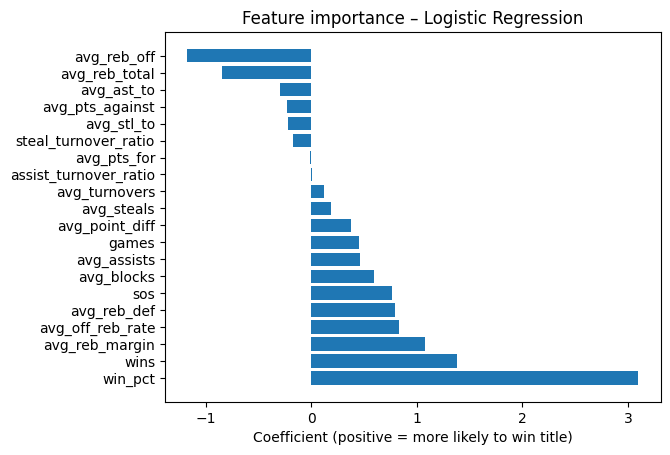

In [27]:
# model trained on random splitting of data

from sklearn.model_selection import train_test_split

features_df = pd.read_csv("team_season_features_v2_clean-2.csv")

num_cols = features_df.select_dtypes(include="number").columns.tolist()
for col in ["champion", "season"]:
    if col in num_cols:
        num_cols.remove(col)

X = features_df[num_cols].copy()
X = X.replace([np.inf, -np.inf], np.nan)
y = features_df["champion"].astype(int)

# --- RANDOM SEASON SPLIT (not per-row) ---
seasons = features_df["season"].unique()
train_seasons, test_seasons = train_test_split(
    seasons, test_size=0.2, random_state=42
)

train_mask = features_df["season"].isin(train_seasons)
test_mask  = features_df["season"].isin(test_seasons)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

id_test = features_df.loc[test_mask, ["season", "team", "champion"]].copy()

model = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(multi_class="ovr",
                               class_weight="balanced",
                               max_iter=10000))
])

model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, probabilities))
print("Average Precision (PR-AUC):", average_precision_score(y_test, probabilities))
pred_labels = (probabilities > 0.5).astype(int)
print("Binary accuracy:", accuracy_score(y_test, pred_labels))

id_test["proba_win"] = probabilities
idx = id_test.groupby("season")["proba_win"].idxmax()

predicted_champs = (
    id_test.loc[idx, ["season", "team", "proba_win"]]
           .rename(columns={"team": "team_pred", "proba_win": "pred_prob"})
           .reset_index(drop=True)
)

true_champs = (
    id_test.loc[id_test["champion"] == 1, ["season", "team"]]
           .rename(columns={"team": "team_true"})
           .reset_index(drop=True)
)

eval = predicted_champs.merge(true_champs, on="season", how="left")
eval["correct"] = (eval["team_pred"] == eval["team_true"]).astype(int)
print("Top-1 accuracy:", eval["correct"].mean())

print("\nPredicted vs. True Champions by Season:\n")
print(eval[["season", "team_pred", "team_true", "pred_prob", "correct"]]
      .sort_values("season")
      .to_string(index=False))

coefs = model.named_steps["clf"].coef_[0]
coef_df = pd.DataFrame({"feature": num_cols, "coef": coefs}).sort_values("coef", ascending=False)

plt.barh(coef_df["feature"], coef_df["coef"])
plt.xlabel("Coefficient (positive = more likely to win title)")
plt.title("Feature importance – Logistic Regression")
plt.show()